# FrequencySeries チュートリアル

このチュートリアルでは、**GWExPy** における `FrequencySeries` の機能と使用方法を解説します。

`FrequencySeries` は周波数領域のデータを扱うためのクラスであり、パワースペクトル密度 (PSD) やフーリエ変換 (FFT) の結果を格納するために使用されます。

## 目次
1. [TimeSeries からの生成 (FFT)](#fft)
2. [プロットと振幅・位相](#plot)
3. [周波数領域での操作 (Crop, Rebin)](#manipulation)
4. [ホワイトニング](#whitening)
5. [データの保存と読み込み](#io)

<a id="fft"></a>
## 1. TimeSeries からの生成 (FFT)

通常、`FrequencySeries` は `TimeSeries` データに対してフーリエ変換を適用することで生成されます。

離散フーリエ変換 (DFT) は以下のように定義されます：

$$
X[k] = \sum_{n=0}^{N-1} x[n] e^{-i 2\pi k n / N}
$$

ここで、$x[n]$ は時系列データ、$X[k]$ は周波数領域のデータです。

In [1]:
import numpy as np

from gwexpy.plot import Plot
from gwexpy.timeseries import TimeSeries

# サンプルデータの生成
duration = 10  # 秒
fs = 1024      # サンプリング周波数 (Hz)
t = np.linspace(0, duration, duration * fs)

# 信号: 30Hz のサイン波 + ノイズ
signal = 1.0 * np.sin(2 * np.pi * 30 * t)
noise = np.random.normal(0, 0.5, len(t))
data = signal + noise

ts = TimeSeries(data, sample_rate=fs, unit='V', name='Sample Data')

# FFT の計算
fs_fft = ts.fft()
print(fs_fft)

FrequencySeries([-0.00131553+0.j        ,
                  0.00933131+0.01220316j,
                  0.00226395-0.0080528j , ...,
                 -0.00444265+0.00498569j,
                 -0.00804843-0.00023407j,
                 -0.01119027+0.j        ]
                unit: V,
                f0: 0.0 Hz,
                df: 0.1 Hz,
                epoch: 0.0,
                name: Sample Data,
                channel: None)


<a id="plot"></a>
## 2. プロットと振幅・位相

`FrequencySeries` は複素数データを保持している場合があり、その振幅 (Magnitue) や位相 (Phase) を簡単に可視化できます。

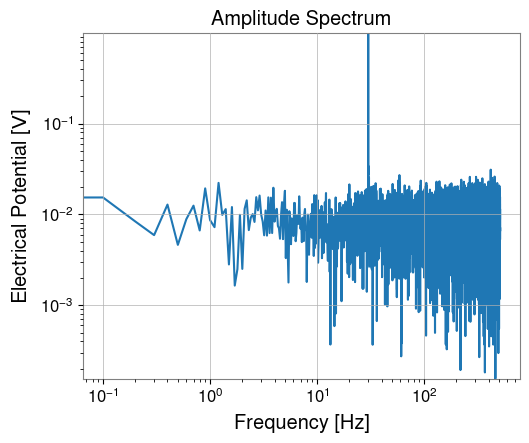

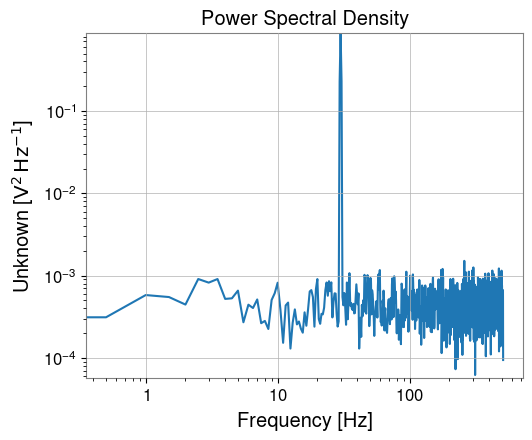

In [2]:
# 振幅スペクトルのプロット
plot = Plot(fs_fft.abs(), xscale='log', yscale='log', title='Amplitude Spectrum')
plot.show()

# PSD (パワー・スペクトル・密度) の計算とプロット
psd = ts.psd(fftlength=2, overlap=1, window='hann')
plot_psd = Plot(psd, xscale='log', yscale='log', title='Power Spectral Density')
plot_psd.show()

<a id="manipulation"></a>
## 3. 周波数領域での操作

### Crop (切り出し)

特定の周波数帯域のみを抽出するには `crop()` を使用します。

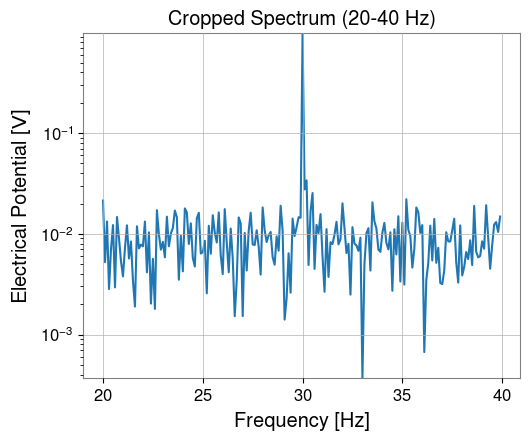

In [3]:
# 20Hz から 40Hz の範囲を抽出
fs_cropped = fs_fft.crop(20, 40)

plot = Plot(fs_cropped.abs(), title='Cropped Spectrum (20-40 Hz)')
plot.show()

### Rebin (再ビン化)

周波数分解能を変更するためにデータを再ビン化します。

Original df: 0.5 Hz Hz
Rebinned df: 2.0 Hz Hz


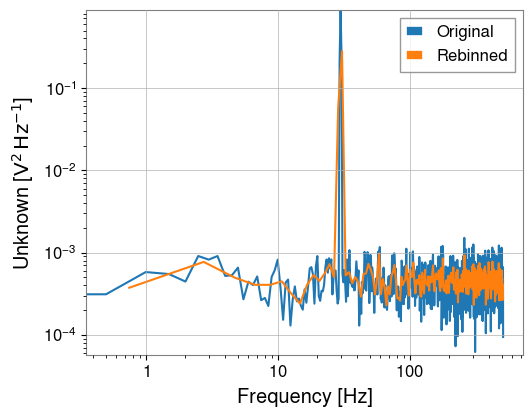

In [4]:
# ビンサイズを粗くする（平均化）
# 現在の df を確認
print(f"Original df: {psd.df} Hz")

# 2倍のビン幅に再ビン化
psd_rebinned = psd.rebin(2)
print(f"Rebinned df: {psd_rebinned.df} Hz")

plot = Plot(psd, psd_rebinned, xscale='log', yscale='log', labels=['Original', 'Rebinned'])
plot.show()

<a id="whitening"></a>
## 4. ホワイトニング

周波数領域でのホワイトニングは、信号をそのノイズスペクトルで正規化する操作です。

$$
X_{whitened}[f] = \frac{X[f]}{\sqrt{S_n[f]}}
$$

ここで $S_n[f]$ はノイズのパワースペクトル密度です。

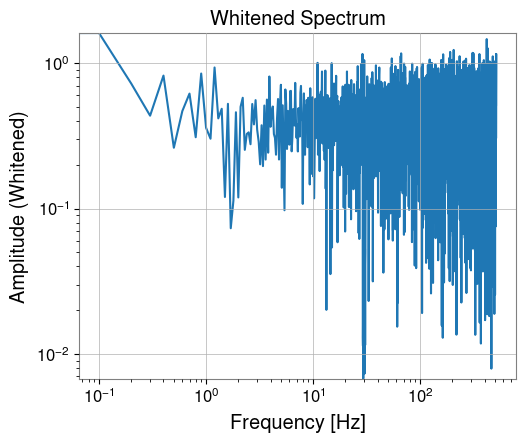

In [5]:
# ノイズモデルとしてのPSDを使用
# 実際にはバックグラウンドノイズのPSDを使用しますが、ここでは信号自身のPSDで代用してデモを行います
asd = psd ** 0.5
# ASD を FFT の周波数分解能に合わせる
asd_interp = asd.interpolate(fs_fft.df.value)
whitened_fft = fs_fft / asd_interp

plot = Plot(whitened_fft.abs(), title='Whitened Spectrum', ylabel='Amplitude (Whitened)')
plot.show()

<a id="io"></a>
## 5. データの保存と読み込み

`FrequencySeries` は HDF5 などの形式で保存したり、Pandas DataFrame に変換したりできます。

In [6]:
# Pandas DataFrame への変換
df = psd.to_pandas()
print(df.head())

frequency
0.0    0.000056
0.5    0.000311
1.0    0.000579
1.5    0.000548
2.0    0.000444
Name: Sample Data, dtype: float64
